Suppose we have two trucking warehouses A and B separated by 200 miles. N trucks travel randomly between A and B with a 250 mile range and 500 kWh batteries. The warehouses are each equipped with C 100kW chargers. 

The trucks travel at 50 mph on average, so the average travel time T between the warehouses is $T_\text{travel} = \frac{\text{200 miles}}{\text{50 miles/h}} = 4$h.

The average down time for charging is $T_\text{down} = \frac{(\text{500 kWh})(\text{200 miles}) / \text{250 miles}}{\text{100 kW}} = 4$h.

1. Suppose a truck arrives at warehouse A and all C chargers are in use. What's the average wait time as a function of the number of chargers?

The probability that we're still waiting for a charger after time t is given by:

$$P_C(t) = (1-t/4h)^C$$

The average wait time is given by:

$$\mu_C = \int_0^\text{4h}tP_C(t)dt$$

which can be evaluated numerically.

Text(0.5, 0, 'Number of chargers')

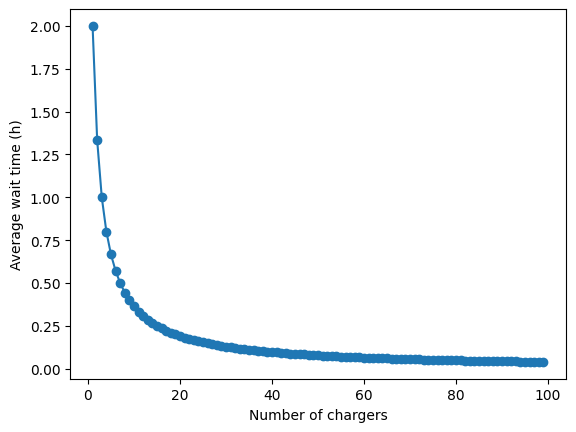

In [49]:
from scipy.integrate import quad
import numpy as np

ts = np.linspace(0, 4, 1000)

average_ts = []
Cs = np.arange(1,100)
for C in Cs:
    def P(t):
        return (1-t/4.)**C
    average_t, res = quad(P, 0, 4)
    average_ts.append(average_t)

import matplotlib.pyplot as plt

plt.plot(Cs, average_ts, 'o-')
plt.ylabel('Average wait time (h)')
plt.xlabel('Number of chargers')

Now suppose there's a queue of Q other trucks waiting to charge. How does the average wait time vary as a function of C and Q?

If there's one truck in the queue, the newly arrived truck will need to wait $\mu_t$ on average for the truck ahead to start charging. The average wait time will then be:

$$\mu(Q=1) = \mu(Q=0) + \int_{\mu(Q=0)}^\text{4h}tP_{C-1}(t)dt$$

In general,

If Q $\leq$ C:

$$\mu(Q) = \mu(Q-1) + \int_{\mu(Q-1)}^\text{4h}tP_{C-Q}(t)dt$$

If Q > C:

Let F = floor(Q/C) and R = Q - FC

$$\mu(Q) = \mu(R) + 4h \cdot F$$

Text(0, 0.5, 'Average wait time (h)')

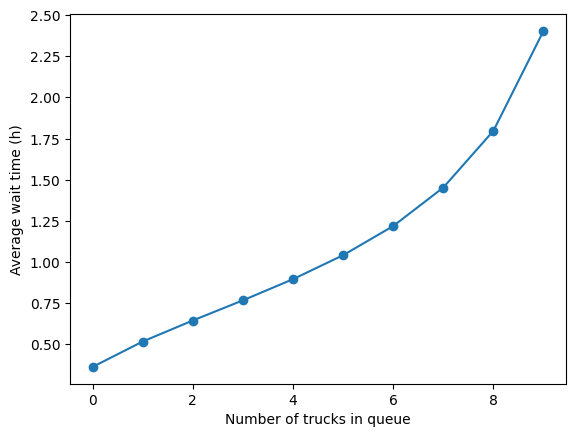

In [48]:
from scipy.integrate import quad
import numpy as np
ts = np.linspace(0, 4, 1000)

C = 10

mu_Qs = []
Qs = np.arange(0, C)
for Q in Qs:
    def P(t):
        return (1-t/4.)**C
    mu_0, res = quad(P, 0, 4)
    mu_last = mu_0
    mu_Q = mu_0
    for i in range(1, Q+1):  
        def P(t):
            return (1-t/4.)**(C-i)
        mu_Q_int, res = quad(P, mu_last, 4)
        mu_Q = mu_last + mu_Q_int
        mu_last = mu_Q 
    mu_Qs.append(mu_Q)

plt.plot(Qs, mu_Qs, 'o-')
plt.xlabel('Number of trucks in queue')
plt.ylabel('Average wait time (h)')
    

2. Now suppose that a truck arrives at warehouse A. If there are N trucks in total, what is the probability that there will be X other trucks there?

Neglecting additional time spent by other trucks waiting to charge at station B, the probability that there will be X other trucks at station A is given by the binomial probability:

$$P(\text{X at A}) = \binom{N-1}{X}\Big(\frac{1}{3}\Big)^X\Big(\frac{2}{3}\Big)^{N-1-X}$$

The for a given number of trucks N and chargers C, the average wait time is then given by:

$$t_\text{wait} = \sum_{X=C}^N P(\text{X at A})\cdot \mu(X-C)$$

where C is the number of chargers at each warehouse. 

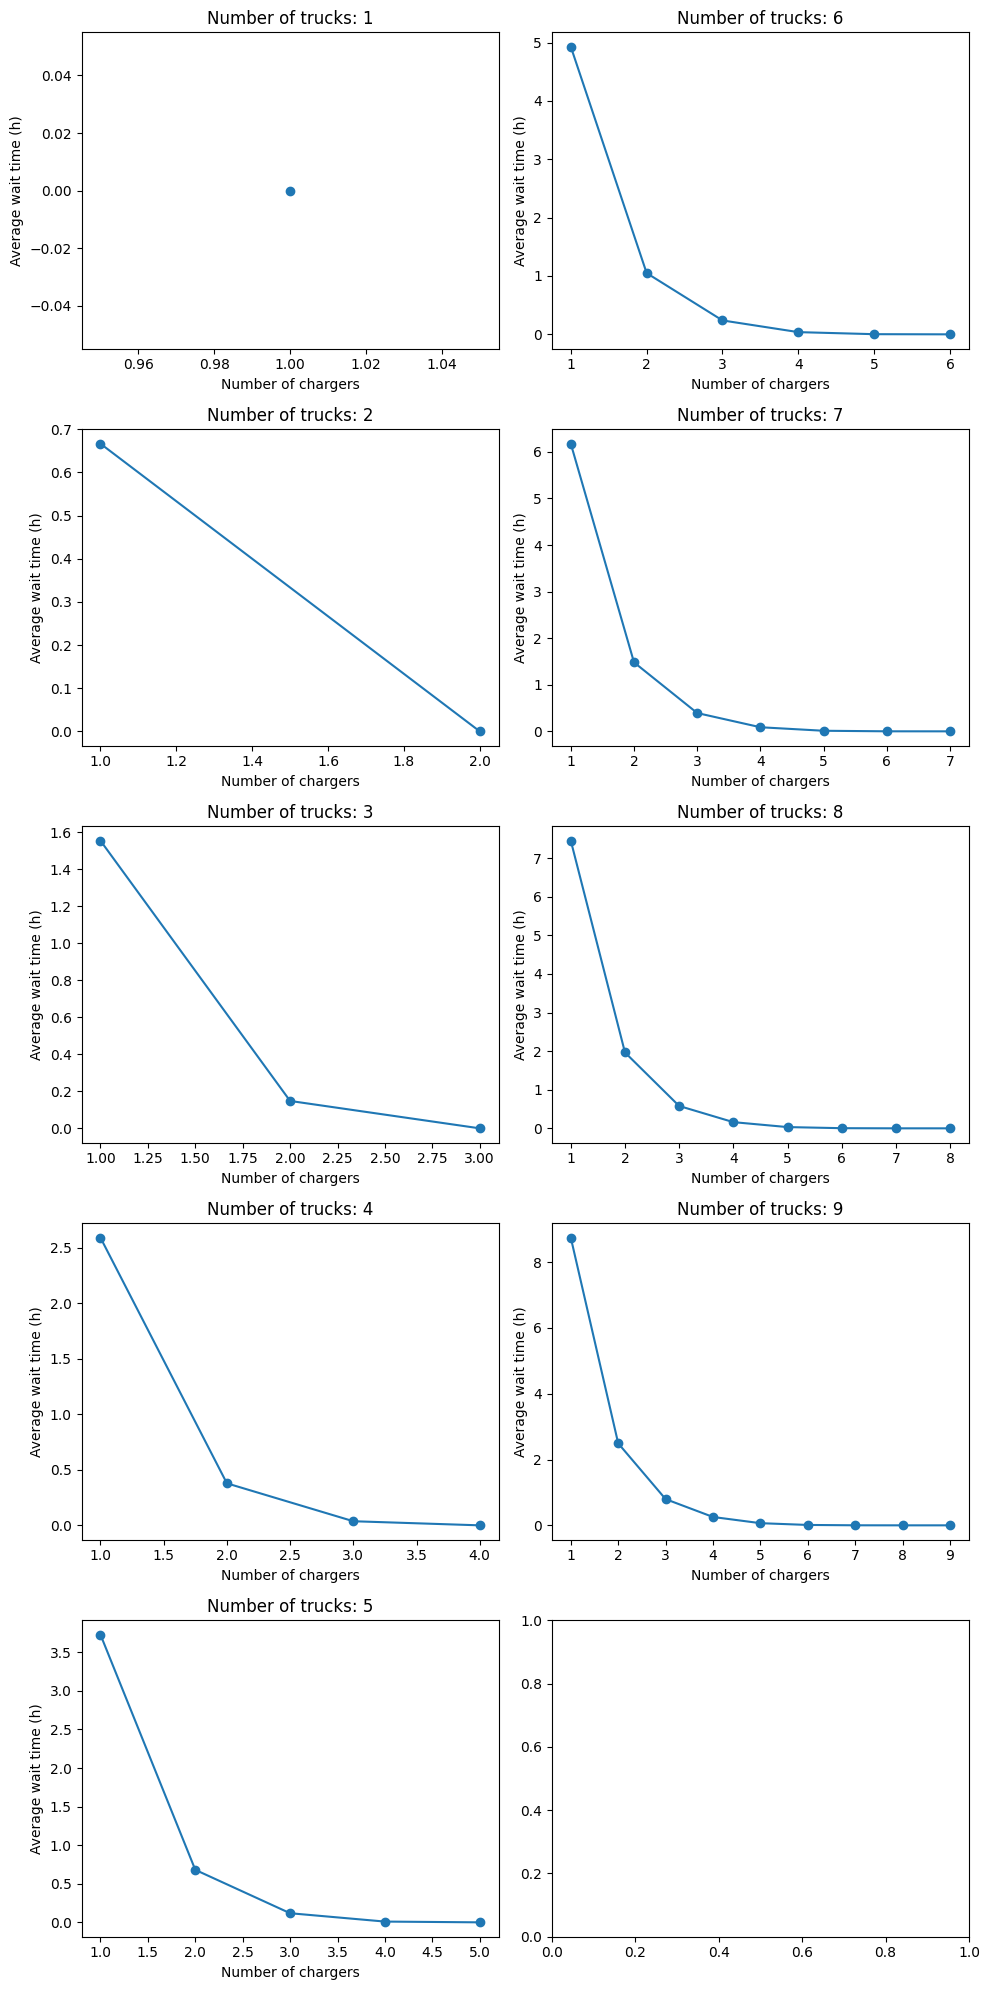

In [68]:
# Make a plot of the average wait time as a function of N and C
import numpy as np
import scipy.special
import matplotlib.pyplot as plt

CHARGING_TIME=4.    # Charging time, in hours

def p_X_at_A(N, X):
    return scipy.special.binom(N-1, X) * (1./3.)**X * (2./3.)**(N-1-X)

# Average wait time for Q <= C
def mu_lt_C(Q, C):
    
    def P_C(t):
        return (1-t/CHARGING_TIME)**C
    
    mu_0, res = quad(P_C, 0, CHARGING_TIME)
    mu_last = mu_0
    mu_Q = mu_0
    for i in range(1, Q+1):  
        def P_C_minus_i(t):
            return (1-t/CHARGING_TIME)**(C-i)
        mu_Q_int, res = quad(P_C_minus_i, mu_last, CHARGING_TIME)
        mu_Q = mu_last + mu_Q_int
        mu_last = mu_Q 
    return mu_Q

# Average wait time in general (Q can be > C)
def mu(Q, C):
    if Q < C:
        return mu_lt_C(Q,C)
    else:
        F = np.floor(Q/C)
        R = int(Q - F*C)
        return mu_lt_C(R, C) + CHARGING_TIME*F

Ns = np.arange(1,10)

fig, axs = plt.subplots(5,2, figsize=(10,20))


i=0
j=0
for N in Ns:
    Cs = []
    t_waits = []
    for C in np.arange(1, N+1):
        Cs.append(C)
        Xs = np.arange(C, N+1)
        t_wait = 0
        for X in Xs:
            Q = X-C
            t_wait += p_X_at_A(N, X) * mu(Q, C)
        t_waits.append(t_wait)
    axs[i,j].plot(Cs, t_waits, 'o-')
    axs[i,j].set_xlabel('Number of chargers')
    axs[i,j].set_ylabel('Average wait time (h)')
    axs[i,j].set_title('Number of trucks: %d'%N)
    i+=1
    if i==5: 
        i=0
        j+=1
    plt.tight_layout()


3. Now let's apply a constraint that the average wait time be below some maximum threshold (say 1h). For a given number of trucks, find the miminum required charger to truck ratio.

0.6666666666666666
1.5555555555555554


Text(0, 0.5, 'Minimum charger ratio to keep average charging wait under 1h')

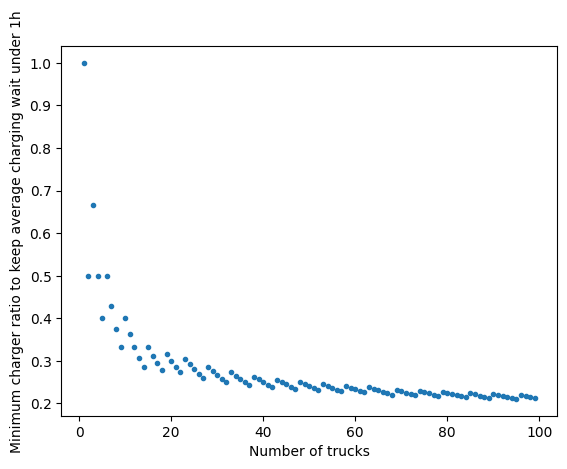

In [67]:
Ns = np.arange(1,100)
MAX_WAIT_TIME=1  # Max allowable wait time, in hours

def average_wait_time(N, C):
    Xs = np.arange(C, N+1)
    t_wait = 0
    for X in Xs:
        Q = X-C
        t_wait += p_X_at_A(N, X) * mu(Q, C)
        
    return t_wait

min_charger_ratios = np.ones(len(Ns))
i_N=0
for N in Ns:
    Cs = np.arange(1,N)
    for C in Cs:
        av_wait = average_wait_time(N, C)
        if av_wait < MAX_WAIT_TIME:
            min_charger_ratios[i_N] = 1.*C/(1.*N)
            break
    i_N += 1
    
# Make a plot of the minimum charger ratio as a function of N
plt.plot(Ns, min_charger_ratios, '.')
plt.xlabel('Number of trucks')
plt.ylabel('Minimum charger ratio to keep average charging wait under 1h')

4. Now suppose we extend the distance between the warehouses to 400 miles such that they require a quick charger in between. The quick charger has a power of 800kW, and an associated charging time of 30 minutes. 

Assuming that we have a high enough charger-to-truck ratio at the warehouses to keep the wait times at the warehouses negligibly small (i.e. below 1h), what is the minimum charger to truck ratio at the quick charger needed to keep the wait time at the quick charger below 30 minutes?

We now have 

$$P(\text{X at quick charger}) = P(\text{X at QC}) = \binom{N-1}{X}\Big(\frac{1}{17}\Big)^X\Big(\frac{16}{17}\Big)^{N-1-X}$$

All the other math remains the same, with a charging time of 30 minutes. 

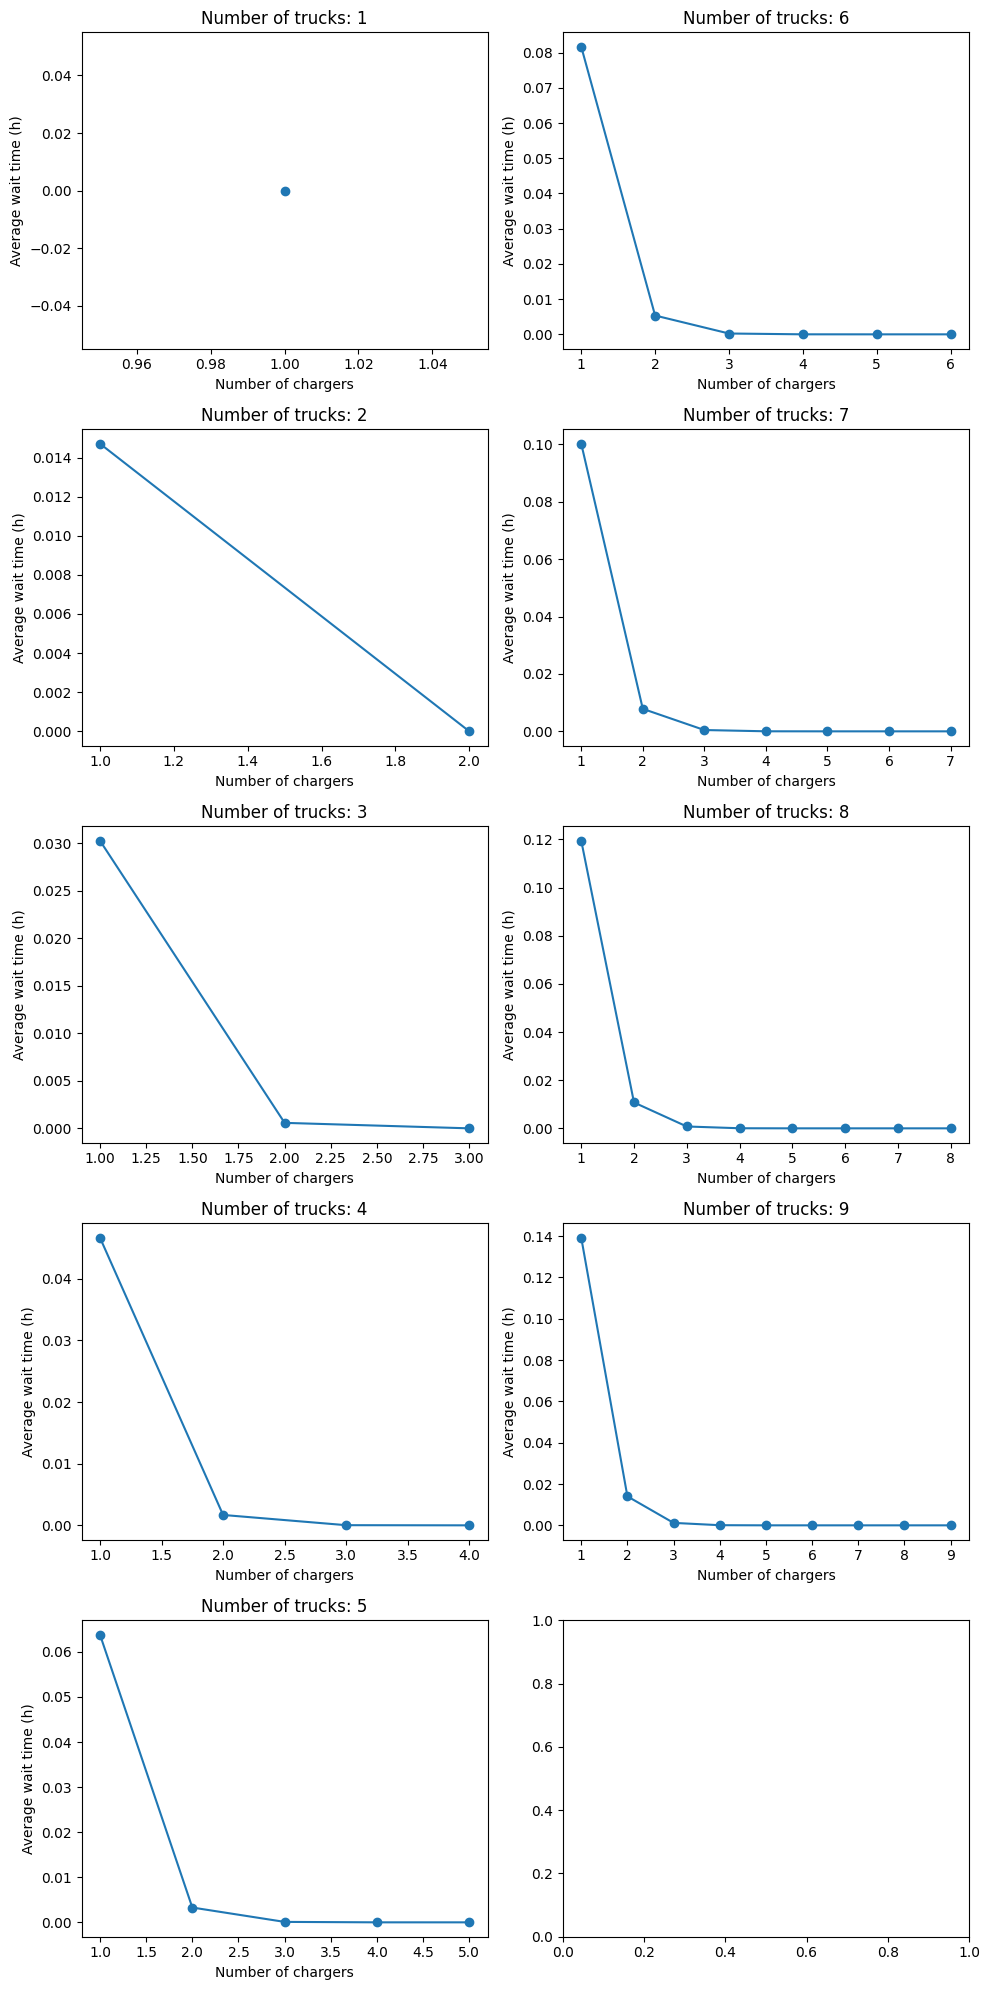

In [2]:
# Make a plot of the average wait time as a function of N and C
from scipy.integrate import quad
import numpy as np
import scipy.special
import matplotlib.pyplot as plt

CHARGING_TIME=0.5    # Charging time, in hours

def p_X_at_A(N, X):
    return scipy.special.binom(N-1, X) * (1./17.)**X * (16./17.)**(N-1-X)

# Average wait time for Q <= C
def mu_lt_C(Q, C):
    
    def P_C(t):
        return (1-t/CHARGING_TIME)**C
    
    mu_0, res = quad(P_C, 0, CHARGING_TIME)
    mu_last = mu_0
    mu_Q = mu_0
    for i in range(1, Q+1):  
        def P_C_minus_i(t):
            return (1-t/CHARGING_TIME)**(C-i)
        mu_Q_int, res = quad(P_C_minus_i, mu_last, CHARGING_TIME)
        mu_Q = mu_last + mu_Q_int
        mu_last = mu_Q 
    return mu_Q

# Average wait time in general (Q can be > C)
def mu(Q, C):
    if Q < C:
        return mu_lt_C(Q,C)
    else:
        F = np.floor(Q/C)
        R = int(Q - F*C)
        return mu_lt_C(R, C) + CHARGING_TIME*F

Ns = np.arange(1,10)

fig, axs = plt.subplots(5,2, figsize=(10,20))


i=0
j=0
for N in Ns:
    Cs = []
    t_waits = []
    for C in np.arange(1, N+1):
        Cs.append(C)
        Xs = np.arange(C, N+1)
        t_wait = 0
        for X in Xs:
            Q = X-C
            t_wait += p_X_at_A(N, X) * mu(Q, C)
        t_waits.append(t_wait)
    axs[i,j].plot(Cs, t_waits, 'o-')
    axs[i,j].set_xlabel('Number of chargers')
    axs[i,j].set_ylabel('Average wait time (h)')
    axs[i,j].set_title('Number of trucks: %d'%N)
    i+=1
    if i==5: 
        i=0
        j+=1
    plt.tight_layout()


Text(0, 0.5, 'Minimum charger ratio to keep average quick charger wait under 30 minutes')

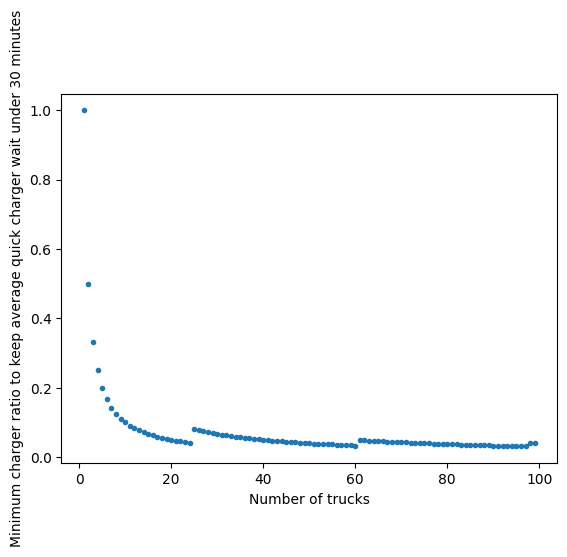

In [5]:
Ns = np.arange(1,100)
MAX_WAIT_TIME=0.5  # Max allowable wait time, in hours

def average_wait_time(N, C):
    Xs = np.arange(C, N+1)
    t_wait = 0
    for X in Xs:
        Q = X-C
        t_wait += p_X_at_A(N, X) * mu(Q, C)
        
    return t_wait

min_charger_ratios = np.ones(len(Ns))
i_N=0
for N in Ns:
    Cs = np.arange(1,N)
    for C in Cs:
        av_wait = average_wait_time(N, C)
        if av_wait < MAX_WAIT_TIME:
            min_charger_ratios[i_N] = 1.*C/(1.*N)
            break
    i_N += 1
    
# Make a plot of the minimum charger ratio as a function of N
plt.plot(Ns, min_charger_ratios, '.')
plt.xlabel('Number of trucks')
plt.ylabel('Minimum charger ratio to keep average quick charger wait under 30 minutes')